In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
!pip install tensorflow
!pip install matplotlib
!pip install pandas
%matplotlib inline
import collections
import math
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve

seed = 54321

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 23.3 MB/s eta 0:00:0000:010:01


# Downloading the data

In [4]:
url = 'https://github.com/ZihanWangKi/CrossWeigh/raw/master/data/'
dir_name = 'data'
#https://github.com/ZihanWangKi/CrossWeigh/raw/master/data/conllpp_train.txt
def download_data(url, filename, download_dir, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""

    # Create directories if they don't exist
    os.makedirs(download_dir, exist_ok=True)

    # If file doesn't exist download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)

    # Check the file size
    statinfo = os.stat(filepath)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filepath)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filepath + '. Can you get to it with a browser?')

    return filepath

# Filepaths to train/valid/test data
train_filepath = download_data(url, 'conllpp_train.txt', dir_name, 3283420)
dev_filepath = download_data(url, 'conllpp_dev.txt', dir_name, 827443)
test_filepath = download_data(url, 'conllpp_test.txt', dir_name, 748737)

Found and verified data/conllpp_train.txt
Found and verified data/conllpp_dev.txt
Found and verified data/conllpp_test.txt


# Reading the data

In [3]:
def read_data(filename):
    '''
    Read data from a file with given file name
    Returns a list of sentences (each sentence a string)
    and list of ner labels for each string
    '''

    print("Reading data ...")
    # manager lists - Holds sentences (list of tokens), ner_labels (for each token an NER label)
    sentences, ner_labels = [], []

    # Open the file
    with open(filename,'r',encoding='latin-1') as f:
        # Read each line
        is_sos = True # We record at each line if we are seeing the beginning of a sentence

        # Tokens and labels of a single sentence, flushed when encountered a new one
        sentence_tokens = []
        sentence_labels = []
        i = 0
        for row in f:
            # If we are seeing an empty line or -DOCSTART- that's a new line
            if len(row.strip()) == 0 or row.split(' ')[0] == '-DOCSTART-':
                is_sos = False
            # Otherwise keep capturing tokens and labels
            else:
                is_sos = True
                token, _, _, ner_label = row.split(' ')
                sentence_tokens.append(token)
                sentence_labels.append(ner_label.strip())

            # When we reach the end or reach the beginning of next
            # add the data to the manager lists, flush the temporary one
            if not is_sos and len(sentence_tokens)>0:
                sentences.append(' '.join(sentence_tokens))
                ner_labels.append(sentence_labels)
                sentence_tokens, sentence_labels = [], []

    print('\tDone')
    return sentences, ner_labels

# Train data
train_sentences, train_labels = read_data(train_filepath)
# Validation data
valid_sentences, valid_labels = read_data(dev_filepath)
# Test data
test_sentences, test_labels = read_data(test_filepath)

# Print some stats
print(f"Train size: {len(train_labels)}")
print(f"Valid size: {len(valid_labels)}")
print(f"Test size: {len(test_labels)}")

# Print some data
print('\nSample data\n')
for v_sent, v_labels in zip(valid_sentences[:5], valid_labels[:5]):
    print(f"Sentence: {v_sent}")
    print(f"Labels: {v_labels}")
    print('\n')

Reading data ...
	Done
Reading data ...
	Done
Reading data ...
	Done
Train size: 14041
Valid size: 3250
Test size: 3452

Sample data

Sentence: CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
Labels: ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sentence: LONDON 1996-08-30
Labels: ['B-LOC', 'O']


Sentence: West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .
Labels: ['B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sentence: Their stay on top , though , may be short-lived as title rivals Essex , Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire .
Labels: ['O', 'O', 'O', 'O', 'O', 'O', '

# Checking the balance of labels

In [4]:
from itertools import chain

# Print the value count for each label
print("Training data label counts")
print(pd.Series(chain(*train_labels)).value_counts())

print("\nValidation data label counts")
print(pd.Series(chain(*valid_labels)).value_counts())

print("\nTest data label counts")
print(pd.Series(chain(*test_labels)).value_counts())

Training data label counts
O         169578
B-LOC       7140
B-PER       6600
B-ORG       6321
I-PER       4528
I-ORG       3704
B-MISC      3438
I-LOC       1157
I-MISC      1155
Name: count, dtype: int64

Validation data label counts
O         42759
B-PER      1842
B-LOC      1837
B-ORG      1341
I-PER      1307
B-MISC      922
I-ORG       751
I-MISC      346
I-LOC       257
Name: count, dtype: int64

Test data label counts
O         38143
B-ORG      1714
B-LOC      1645
B-PER      1617
I-PER      1161
I-ORG       881
B-MISC      722
I-LOC       259
I-MISC      252
Name: count, dtype: int64


# Analyzing the sequence length

In [5]:
pd.Series(train_sentences).str.split().str.len().describe(percentiles=[0.05, 0.95])

count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
5%           2.000000
50%         10.000000
95%         37.000000
max        113.000000
dtype: float64

# Padding/truncating sentences to create arrays

In [6]:
def get_label_id_map(train_labels):
    # Get the unique list of labels
    unique_train_labels = pd.Series(chain(*train_labels)).unique()
    # Create a class label -> class ID mapping
    labels_map = dict(zip(unique_train_labels, np.arange(unique_train_labels.shape[0])))
    print(f"labels_map: {labels_map}")
    return labels_map

In [7]:
labels_map = get_label_id_map(train_labels)

labels_map: {'B-ORG': 0, 'O': 1, 'B-MISC': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-ORG': 6, 'I-MISC': 7, 'I-LOC': 8}


In [8]:
def get_padded_int_labels(labels, labels_map, max_seq_length, return_mask=True):

    # Convert string labels to integers
    int_labels = [[labels_map[x] for x in one_seq] for one_seq in labels]


    # Pad sequences
    if return_mask:
        # If we return mask, we first pad with a special value (-1) and
        # use that to create the mask and later replace -1 with 'O'
        padded_labels = np.array(
            tf.keras.preprocessing.sequence.pad_sequences(
                int_labels, maxlen=max_seq_length, padding='post', truncating='post', value=-1
            )
        )

        # mask filter
        mask_filter = (padded_labels != -1)
        # replace -1 with 'O' s ID
        padded_labels[~mask_filter] = labels_map['O']
        return padded_labels, mask_filter.astype('int')

    else:
        padded_labels = np.array(ner_pad_sequence_func(int_labels, value=labels_map['O']))
        return padded_labels

# Defining hyperparameters

In [9]:
# The maximum length of sequences
max_seq_length = 40

# Size of token embeddings
embedding_size = 64

# Number of hidden units in the RNN layer
rnn_hidden_size = 64

# Number of output nodes in the last layer
n_classes = 9

# Number of samples in a batch
batch_size = 64

# Number of epochs to train
epochs = 3

# Processing the labels

In [10]:
max_seq_length = 40
# Convert string labels to integers for all train/validation/test data
# Pad train/validation/test data
padded_train_labels, train_mask = get_padded_int_labels(train_labels, labels_map, max_seq_length, return_mask=True)

padded_valid_labels, valid_mask = get_padded_int_labels(valid_labels, labels_map, max_seq_length, return_mask=True)

padded_test_labels, test_mask  = get_padded_int_labels(test_labels, labels_map, max_seq_length, return_mask=True)

# Print some labels IDs
print(padded_train_labels[:2])
print(train_mask[:2])

[[0 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


#  Defining the model
We’ll define the model here. Our model will have an embedding layer, followed by a simple RNN layer, and finally, a dense prediction layer. One thing to note in the work we have done so far is that we haven’t yet defined a Tokenizer object. Although the Tokenizer has been an important part of our NLP pipeline to convert each token (or word) into an ID, there’s a big downside to using an external tokenizer. After training the model, if we forget to save the tokenizer along with the model, our machine learning model becomes useless: to combat this, during inference, we would need to map each word to the exact ID it was mapped to during training.

This is a significant risk the tokenizer poses. We’ll seek an alternative where we’ll integrate the tokenization mechanism right into our model so that we don’t need to worry about it later. The figure depicts the overall architecture of the mode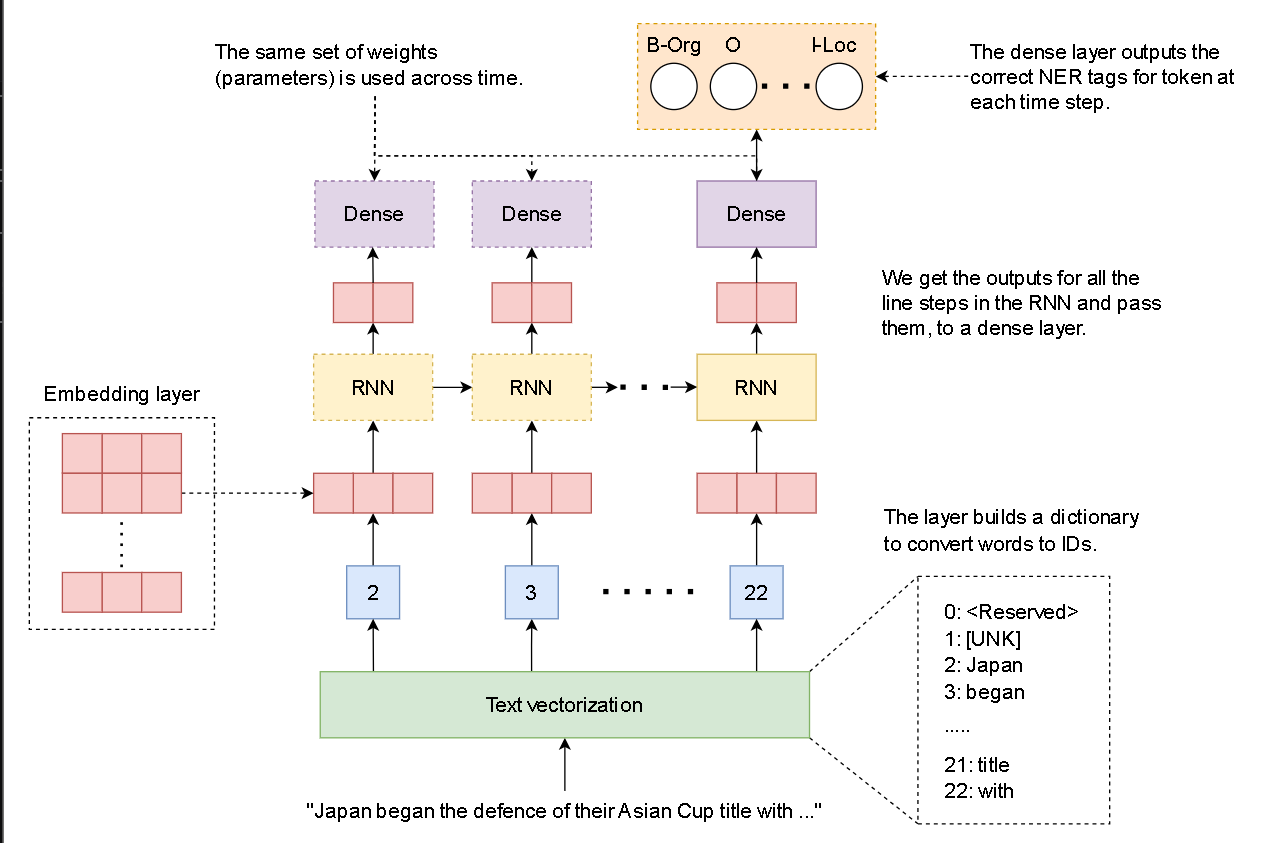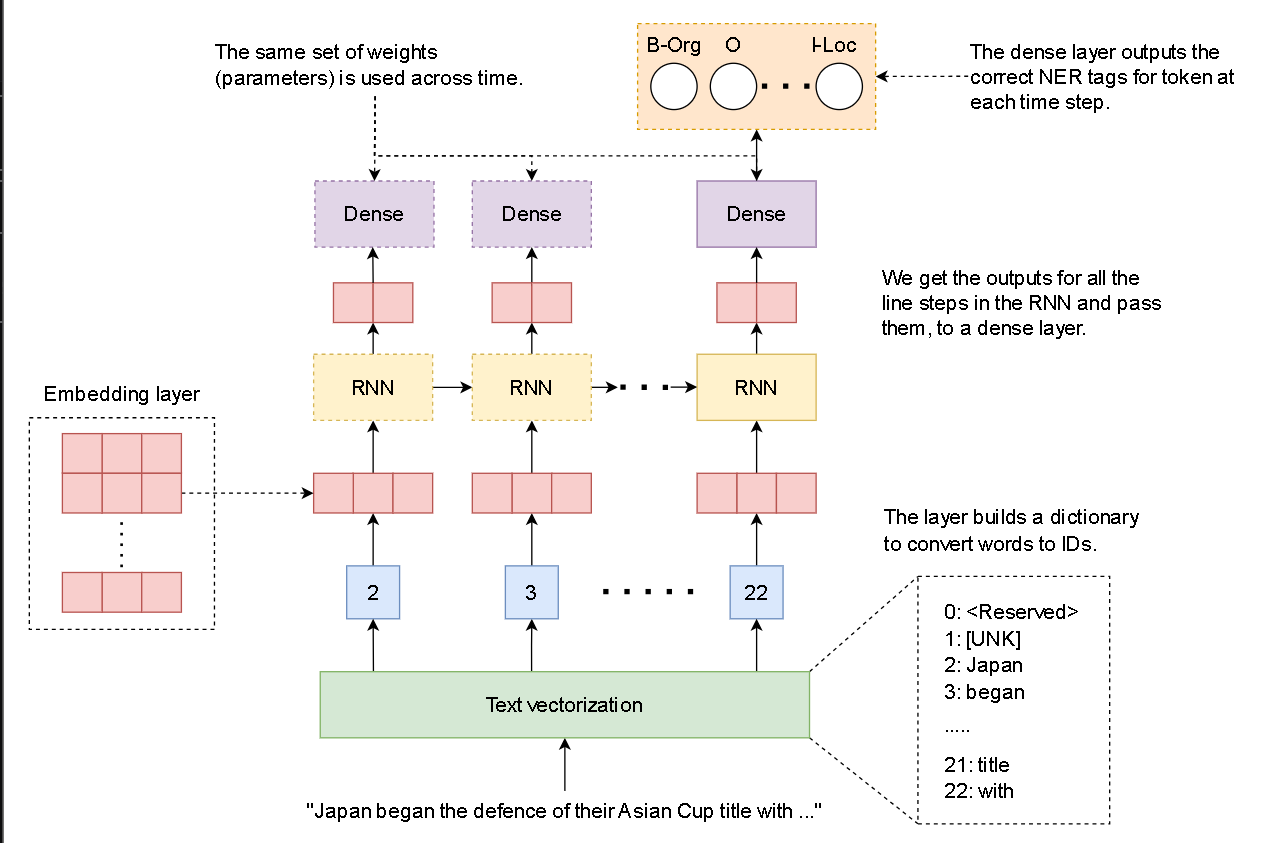png)

# Introduction to the TextVectorization layer

In [11]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

K.clear_session()

toy_corpus = ["I went to the market on Sunday", "The Market was empty."]
toy_vectorization_layer = TextVectorization()

# Fit it on a corpus of data
toy_vectorization_layer.adapt(toy_corpus)

toy_vectorized_output = toy_vectorization_layer(toy_corpus)
toy_vocabulary = toy_vectorization_layer.get_vocabulary()

print("With default arguments\n")
print(f"Data: \n{toy_vectorized_output}")
print(f"Vocabulary: {toy_vocabulary}")
print('-'*50)

toy_vectorization_layer = TextVectorization(max_tokens=5)
toy_vectorization_layer.adapt(toy_corpus)

print("\nWith limited vocabulary\n")
print(f"Data: \n{toy_vectorization_layer(toy_corpus)}")
print(f"Vocabulary: {toy_vectorization_layer.get_vocabulary()}")
print('-'*50)

toy_vectorization_layer = TextVectorization(standardize=None)
toy_vectorization_layer.adapt(toy_corpus)

print("\nWith preprocessing disabled\n")
print(f"Data: \n{toy_vectorization_layer(toy_corpus)}")
print(f"Vocabulary: {toy_vectorization_layer.get_vocabulary()}")
print('-'*50)

toy_vectorization_layer = TextVectorization(output_sequence_length=4)
toy_vectorization_layer.adapt(toy_corpus)

print("\nWith a maximum sequence length\n")
print(f"Data: \n{toy_vectorization_layer(toy_corpus)}")
print(f"Vocabulary: {toy_vectorization_layer.get_vocabulary()}")
print('-'*50)

With default arguments

Data: 
[[ 9  4  6  2  3  8  7]
 [ 2  3  5 10  0  0  0]]
Vocabulary: ['', '[UNK]', 'the', 'market', 'went', 'was', 'to', 'sunday', 'on', 'i', 'empty']
--------------------------------------------------

With limited vocabulary

Data: 
[[1 4 1 2 3 1 1]
 [2 3 1 1 0 0 0]]
Vocabulary: ['', '[UNK]', 'the', 'market', 'went']
--------------------------------------------------

With preprocessing disabled

Data: 
[[12  2  4  5  7  6 10]
 [ 9 11  3  8  0  0  0]]
Vocabulary: ['', '[UNK]', 'went', 'was', 'to', 'the', 'on', 'market', 'empty.', 'The', 'Sunday', 'Market', 'I']
--------------------------------------------------

With a maximum sequence length

Data: 
[[ 9  4  6  2]
 [ 2  3  5 10]]
Vocabulary: ['', '[UNK]', 'the', 'market', 'went', 'was', 'to', 'sunday', 'on', 'i', 'empty']
--------------------------------------------------


# Implementing a recurrent neural network

In [12]:
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


def get_fitted_token_vectorization_layer(corpus, max_seq_length, vocabulary_size=None):
    """ Fit a TextVectorization layer on given data """

    # Define a text vectorization layer
    vectorization_layer = TextVectorization(
        max_tokens=vocabulary_size, standardize=None,
        output_sequence_length=max_seq_length,
    )
    # Fit it on a corpus of data
    vectorization_layer.adapt(corpus)

    # Get the vocabulary size
    n_vocab = len(vectorization_layer.get_vocabulary())

    return vectorization_layer, n_vocab


# Input layer
word_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Text vectorize layer
vectorize_layer, n_vocab = get_fitted_token_vectorization_layer(train_sentences, max_seq_length)

# Vectorized output (each word mapped to an int ID)
vectorized_out = vectorize_layer(word_input)

# Look up embeddings for the returned IDs
embedding_layer = layers.Embedding(input_dim=n_vocab, output_dim=embedding_size, mask_zero=True)(vectorized_out)

# Define a simple RNN layer; it returns an output at each position
rnn_layer = layers.SimpleRNN(
    units=rnn_hidden_size, return_sequences=True
)

rnn_out = rnn_layer(embedding_layer)

dense_layer = layers.Dense(n_classes, activation='softmax')
dense_out = dense_layer(rnn_out)

model = tf.keras.Model(inputs=word_input, outputs=dense_out)

# Defining a custom metric and compiling the model


In [13]:
def macro_accuracy(y_true, y_pred):

    # [batch size * time]
    y_true = tf.cast(tf.reshape(y_true, [-1]), 'int32')
    y_pred = tf.cast(tf.reshape(tf.argmax(y_pred, axis=-1), [-1]), 'int32')

    sorted_y_true = tf.sort(y_true)
    sorted_inds = tf.argsort(y_true)

    sorted_y_pred = tf.gather(y_pred, sorted_inds)

    sorted_correct = tf.cast(tf.math.equal(sorted_y_true, sorted_y_pred), 'int32')

    # We are adding one to make sure there is no division by zero
    correct_for_each_label = tf.cast(tf.math.segment_sum(sorted_correct, sorted_y_true), 'float32') + 1
    all_for_each_label = tf.cast(tf.math.segment_sum(tf.ones_like(sorted_y_true), sorted_y_true), 'float32') + 1

    mean_accuracy = tf.reduce_mean(correct_for_each_label/all_for_each_label)

    return mean_accuracy

In [14]:
mean_accuracy_metric = tf.keras.metrics.MeanMetricWrapper(fn=macro_accuracy, name='macro_accuracy')

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[mean_accuracy_metric])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 40)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 40, 64)            1512000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 40, 64)            8256      
                                                                 
 dense (Dense)               (None, 40, 9)             585       
                                                                 
Total params: 1520841 (5.80 MB)
Trainable params: 1520841 (5.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

# Training the model

In [15]:
def get_class_weights(train_labels):

    label_count_ser = pd.Series(chain(*train_labels)).value_counts()
    label_count_ser = label_count_ser.sum()/label_count_ser
    label_count_ser /= label_count_ser.max()

    label_id_map = get_label_id_map(train_labels)
    label_count_ser.index = label_count_ser.index.map(label_id_map)
    return label_count_ser.to_dict()

def get_sample_weights_from_class_weights(labels, class_weights):
    """ From the class weights, generate sample weights """
    return np.vectorize(class_weights.get)(labels)


train_class_weights = get_class_weights(train_labels)
print(f"Class weights: {train_class_weights}")

labels_map: {'B-ORG': 0, 'O': 1, 'B-MISC': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-ORG': 6, 'I-MISC': 7, 'I-LOC': 8}
Class weights: {1: 0.006811025015037328, 5: 0.16176470588235295, 3: 0.17500000000000002, 0: 0.18272425249169436, 4: 0.25507950530035334, 6: 0.31182505399568033, 2: 0.33595113438045376, 8: 0.9982713915298186, 7: 1.0}


In [16]:
# Make train_sequences an array
train_sentences = np.array(train_sentences)
train_sample_weights = get_sample_weights_from_class_weights(padded_train_labels, train_class_weights)

# Training the model
model.fit(train_sentences, padded_train_labels, sample_weight=train_sample_weights, batch_size=batch_size, epochs=epochs, validation_data=(np.array(valid_sentences), padded_valid_labels))

Epoch 1/3
220/220 [==============================] - 11s 39ms/step - loss: 0.0844 - macro_accuracy: 0.5689 - val_loss: 1.2188 - val_macro_accuracy: 0.7107
Epoch 2/3
220/220 [==============================] - 8s 37ms/step - loss: 0.0255 - macro_accuracy: 0.8905 - val_loss: 0.4510 - val_macro_accuracy: 0.8088
Epoch 3/3
220/220 [==============================] - 8s 37ms/step - loss: 0.0086 - macro_accuracy: 0.9581 - val_loss: 0.2656 - val_macro_accuracy: 0.8061


In [17]:
model.evaluate(np.array(test_sentences), padded_test_labels)

108/108 [==============================] - 1s 6ms/step - loss: 0.3718 - macro_accuracy: 0.7655


[0.37183207273483276, 0.7654591202735901]

# Visually analyzing outputs

In [18]:
n_samples = 5
visual_test_sentences = test_sentences[:n_samples]
visual_test_labels = padded_test_labels[:n_samples]

visual_test_predictions = model.predict(np.array(visual_test_sentences))
visual_test_pred_labels = np.argmax(visual_test_predictions, axis=-1)

rev_labels_map = dict(zip(labels_map.values(), labels_map.keys()))
for i, (sentence, sent_labels, sent_preds) in enumerate(zip(visual_test_sentences, visual_test_labels, visual_test_pred_labels)):
    n_tokens = len(sentence.split())
    print("Sample:\t","\t".join(sentence.split()))
    print("True:\t","\t".join([rev_labels_map[i] for i in sent_labels[:n_tokens]]))
    print("Pred:\t","\t".join([rev_labels_map[i] for i in sent_preds[:n_tokens]]))
    print("\n")


1/1 [==============================] - 0s 377ms/step
Sample:	 SOCCER	-	JAPAN	GET	LUCKY	WIN	,	CHINA	IN	SURPRISE	DEFEAT	.
True:	 O	O	B-LOC	O	O	O	O	B-LOC	O	O	O	O
Pred:	 O	O	B-PER	I-PER	O	O	O	B-ORG	O	O	O	O


Sample:	 Nadim	Ladki
True:	 B-PER	I-PER
Pred:	 B-PER	B-PER


Sample:	 AL-AIN	,	United	Arab	Emirates	1996-12-06
True:	 B-LOC	O	B-LOC	I-LOC	I-LOC	O
Pred:	 B-PER	O	B-LOC	I-LOC	I-ORG	I-ORG


Sample:	 Japan	began	the	defence	of	their	Asian	Cup	title	with	a	lucky	2-1	win	against	Syria	in	a	Group	C	championship	match	on	Friday	.
True:	 B-LOC	O	O	O	O	O	B-MISC	I-MISC	O	O	O	O	O	O	O	B-LOC	O	O	O	O	O	O	O	O	O
Pred:	 B-LOC	O	O	O	O	O	B-MISC	I-MISC	I-MISC	O	O	O	O	O	O	B-LOC	O	O	O	O	O	O	O	O	O


Sample:	 But	China	saw	their	luck	desert	them	in	the	second	match	of	the	group	,	crashing	to	a	surprise	2-0	defeat	to	newcomers	Uzbekistan	.
True:	 O	B-LOC	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	B-LOC	O
Pred:	 O	B-LOC	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O




# Defining an advance RNN model

In [19]:
vocab_ser = pd.Series(pd.Series(train_sentences).str.split().explode().unique())
vocab_ser.str.len().describe(percentiles=[0.05, 0.95])

count    23623.000000
mean         6.832705
std          2.749288
min          1.000000
5%           3.000000
50%          7.000000
95%         12.000000
max         61.000000
dtype: float64

## Testing `TextVectorization` for char level

In [20]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

def split_char(token):
    """ Instead of splitting word by word, split each char"""
    return tf.strings.bytes_split(token)


# Define a vectorization layer that splits chars
vectorization_layer = TextVectorization(
        standardize=None,
        split=split_char,
)


def prepare_corpus_for_char_embeddings(tokenized_sentences, max_seq_length):
    """ Pads each sequence to a maximum length """
    proc_sentences = []
    for tokens in tokenized_sentences:
        if len(tokens) >= max_seq_length:
            proc_sentences.append([[t] for t in tokens[:max_seq_length]])
        else:
            proc_sentences.append([[t] for t in tokens+['']*(max_seq_length-len(tokens))])

    return proc_sentences

# Define sample data
data = ['aaaa bb c', 'd eee']
# Pad sequences
tokenized_sentences = prepare_corpus_for_char_embeddings([d.split() for d in data], 3)
print(f"Padded sequence: {tokenized_sentences}")

# Fit it on a corpus of data
vectorization_layer.adapt(tokenized_sentences)

# Print data
print(f"Vectorized output: {vectorization_layer(tokenized_sentences)}")
print(f"Vocabulary: {vectorization_layer.get_vocabulary()}")

Padded sequence: [[['aaaa'], ['bb'], ['c']], [['d'], ['eee'], ['']]]
Vectorized output: [[[2 2 2 2]
  [4 4 0 0]
  [6 0 0 0]]

 [[5 0 0 0]
  [3 3 3 0]
  [0 0 0 0]]]
Vocabulary: ['', '[UNK]', 'a', 'e', 'b', 'd', 'c']


In [21]:
def _split_char(token):
    return tf.strings.bytes_split(token)

_split_char(tf.constant(['abcd']))

<tf.RaggedTensor [[b'a', b'b', b'c', b'd']]>

## Defining the model

In [22]:
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

K.clear_session()
max_seq_length = 40
max_token_length = 12

def get_fitted_token_vectorization_layer(corpus, max_seq_length, vocabulary_size=None):
    """ Fit a TextVectorization layer on given data """

    # Define a text vectorization layer
    vectorization_layer = TextVectorization(
        max_tokens=vocabulary_size, standardize=None,
        output_sequence_length=max_seq_length,
    )
    # Fit it on a corpus of data
    vectorization_layer.adapt(corpus)

    # Get the vocabulary size
    n_vocab = len(vectorization_layer.get_vocabulary())

    return vectorization_layer, n_vocab


def get_fitted_char_vectorization_layer(corpus, max_seq_length, max_token_length, vocabulary_size=None):
    """ Fit a TextVectorization layer on given data """

    def _split_char(token):
        return tf.strings.bytes_split(token)

    # Define a text vectorization layer
    vectorization_layer = TextVectorization(
        standardize=None,
        split=_split_char,
        output_sequence_length=max_token_length,
    )

    tokenized_sentences = [sent.split() for sent in corpus]
    padded_tokenized_sentences = prepare_corpus_for_char_embeddings(tokenized_sentences, max_seq_length)

    # Fit it on a corpus of data
    vectorization_layer.adapt(padded_tokenized_sentences)

    # Get the vocabulary size
    n_vocab = len(vectorization_layer.get_vocabulary())

    return vectorization_layer, n_vocab


# Input layer (tokens)
word_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# --------------------- Token-based text vectorizer + Embeddings ----------------------- #
# Text vectorize layer (token)
token_vectorize_layer, n_token_vocab = get_fitted_token_vectorization_layer(train_sentences, max_seq_length)

# Vectorized output (each word mapped to an int ID)
token_vectorized_out = token_vectorize_layer(word_input)

# Look up embeddings for the returned IDs
token_embedding_out = layers.Embedding(input_dim=n_token_vocab, output_dim=64, mask_zero=True)(token_vectorized_out)

# ---------------------------------------------------------------------------------------#

# -------------- Char-based text vectorizer + convolutional embeddings ----------------- #

# Text vectorize layer (char)
char_vectorize_layer, n_char_vocab = get_fitted_char_vectorization_layer(train_sentences, max_seq_length, max_token_length)

# Vectorized output of each token
# Need a [batch size, seq len, 1]
# strings.split() returns a RaggedTensor. It needs to be converted to a Tensor. Otherwise the following error will be raised
# InvalidArgumentError:  assertion failed: [the given axis (axis = 2) is not squeezable!]
#	 [[node model/text_vectorization_1/RaggedSqueeze/Assert/Assert (defined at <ipython-input-26-a2f55ee22434>:17) ]] [Op:__inference_train_function_72435]
tokenized_word_input = layers.Lambda(
    lambda x: tf.strings.split(x).to_tensor(default_value='', shape=[None, max_seq_length, 1])
)(word_input)
char_vectorized_out = char_vectorize_layer(tokenized_word_input)


# Produces a [batch size, seq length, token_length, emb size]
char_embedding_layer = layers.Embedding(input_dim=n_char_vocab, output_dim=32, mask_zero=True)(char_vectorized_out)

# A 1D convolutional layer that will generate token embeddings by shifting a convolutional kernel over
# the sequence of chars in each token (padded)
char_token_output = layers.Conv1D(filters=1, kernel_size=5, strides=1, padding='same', activation='relu')(char_embedding_layer)
# There is an additional dimension of size 1 (out channel dimension) that we need to remove
char_token_output = layers.Lambda(lambda x: x[:, :, :, 0])(char_token_output)

# ---------------------------------------------------------------------------------------#

# Concatenate the token and char embeddings
concat_embedding_out = layers.Concatenate()([token_embedding_out, char_token_output])

# Define a simple RNN layer; it returns an output at each position
rnn_layer_1 = layers.SimpleRNN(
    units=64, activation='tanh', use_bias=True, return_sequences=True
)

rnn_out_1 = rnn_layer_1(concat_embedding_out)

# Define the final prediction layer
dense_layer = layers.Dense(n_classes, activation='softmax')
dense_out = dense_layer(rnn_out_1)

# Define the model
char_token_embedding_rnn = tf.keras.Model(inputs=word_input, outputs=dense_out)

# Define a macro accuracy measure
mean_accuracy_metric = tf.keras.metrics.MeanMetricWrapper(fn=macro_accuracy, name='macro_accuracy')

# Compile the model with a loss optimizer and metrics
char_token_embedding_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[mean_accuracy_metric])

# Summary of the model
char_token_embedding_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 lambda (Lambda)             (None, 40, 1)                0         ['input_1[0][0]']             
                                                                                                  
 text_vectorization_1 (Text  (None, 40, 12)               0         ['lambda[0][0]']              
 Vectorization)                                                                                   
                                                                                                  
 embedding_1 (Embedding)     (None, 40, 12, 32)           2752      ['text_vectorization_1[0][

In [23]:
def get_sample_weights_from_class_weights(labels, class_weights):
    """ From the class weights generate sample weights """
    return np.vectorize(class_weights.get)(labels)

train_class_weights = get_class_weights(train_labels)
print(f"Class weights: {train_class_weights}")

# Make train_sequences an array
train_sentences = np.array(train_sentences)
# Get sample weights (we cannot use class_weight with TextVectorization layer)
train_sample_weights = get_sample_weights_from_class_weights(padded_train_labels, train_class_weights)

# Training the model
char_token_embedding_rnn.fit(
    train_sentences, padded_train_labels,
    sample_weight=train_sample_weights,
    batch_size=64,
    epochs=3,
    validation_data=(np.array(valid_sentences), padded_valid_labels)
)

labels_map: {'B-ORG': 0, 'O': 1, 'B-MISC': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-ORG': 6, 'I-MISC': 7, 'I-LOC': 8}
Class weights: {1: 0.006811025015037328, 5: 0.16176470588235295, 3: 0.17500000000000002, 0: 0.18272425249169436, 4: 0.25507950530035334, 6: 0.31182505399568033, 2: 0.33595113438045376, 8: 0.9982713915298186, 7: 1.0}
Epoch 1/3
220/220 [==============================] - 18s 63ms/step - loss: 0.0800 - macro_accuracy: 0.5629 - val_loss: 1.1123 - val_macro_accuracy: 0.7251
Epoch 2/3
220/220 [==============================] - 13s 61ms/step - loss: 0.0240 - macro_accuracy: 0.8853 - val_loss: 0.4846 - val_macro_accuracy: 0.8118
Epoch 3/3
220/220 [==============================] - 13s 60ms/step - loss: 0.0083 - macro_accuracy: 0.9600 - val_loss: 0.2686 - val_macro_accuracy: 0.8235


In [24]:
char_token_embedding_rnn.evaluate(np.array(test_sentences), padded_test_labels)

108/108 [==============================] - 1s 8ms/step - loss: 0.3714 - macro_accuracy: 0.7929


[0.37138494849205017, 0.7929403185844421]